In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

In [2]:
batchSizeTrain = 64
batchSizeTest = 1000
trainLoader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batchSizeTrain, shuffle=True)

testLoader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batchSizeTest, shuffle=True)

Example Batch #0
Input Shape: torch.Size([64, 1, 28, 28])


Text(0.5, 1.0, 'Ground Truth: 2')

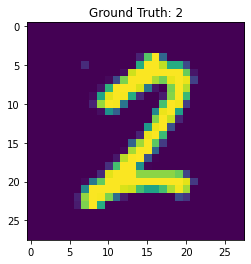

In [3]:
exBatchIdx, (exData, exLabels) = next(enumerate(trainLoader))

print(f"Example Batch #{exBatchIdx}")
print(f"Input Shape: {exData.shape}")
exInputIdx = np.random.randint(batchSizeTrain)
plt.imshow(exData[exInputIdx][0])
plt.title(f"Ground Truth: {exLabels[exInputIdx]}")

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encode1 = nn.Linear(28*28, 100)
        self.encode2 = nn.Linear(100, 64)
        self.encode3 = nn.Linear(64, 64)
        self.encode4 = nn.Linear(64, 10)
        
        self.decode1 = nn.Linear(10, 64)
        self.decode2 = nn.Linear(64, 64)
        self.decode3 = nn.Linear(64, 100)
        self.decode4 = nn.Linear(100, 28*28)
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        x = F.relu(self.encode1(x))
        x = F.relu(self.encode2(x))
        x = F.relu(self.encode3(x))
        x = F.relu(self.encode4(x))
        
        x = F.relu(self.decode1(x))
        x = F.relu(self.decode2(x))
        x = F.relu(self.decode3(x))
        x = F.relu(self.decode4(x))
        
        x = x.view(-1, 1, 28, 28)
        return x

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0)
model = AutoEncoder()
model.apply(init_weights)

AutoEncoder(
  (encode1): Linear(in_features=784, out_features=100, bias=True)
  (encode2): Linear(in_features=100, out_features=64, bias=True)
  (encode3): Linear(in_features=64, out_features=64, bias=True)
  (encode4): Linear(in_features=64, out_features=10, bias=True)
  (decode1): Linear(in_features=10, out_features=64, bias=True)
  (decode2): Linear(in_features=64, out_features=64, bias=True)
  (decode3): Linear(in_features=64, out_features=100, bias=True)
  (decode4): Linear(in_features=100, out_features=784, bias=True)
)

In [6]:
n_epochs = 15
learning_rate = 0.0003
loss_beta = 0.99
loss_running_avg = 0
losses = []

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
def plot():
    plt.title("Training")
    plt.xlabel("Batch Number")
    plt.ylabel("Loss")
    plt.plot(losses)
    plt.pause(0.001)
    display.clear_output(wait=True)

In [8]:
t = 0
for epoch in range(n_epochs):
    for batch_idx, (inputs, _) in enumerate(trainLoader):        
        t += 1
        
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        loss_running_avg = loss_beta * loss_running_avg + (1-loss_beta) * loss.item()
        losses.append(loss_running_avg / (1 - loss_beta**t))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            plot()
    print(f"Epoch #{epoch+1} Loss Running Average: {loss_running_avg}")

print(f"Average Training Loss: {avgTrainLoss}")

Epoch #15 Loss Running Average: 0.5026325437940253
Average Training Loss: 0.5743104558170646


In [58]:
avgTrainLoss = 0
nTrainBatches = 0
for batch_idx, (inputs, _) in enumerate(trainLoader):
    outputs = model(inputs)
    loss = criterion(outputs, inputs)
    avgTrainLoss += loss.item()
    
    nTrainBatches += 1
    
avgTrainLoss /= nTrainBatches
print(f"Average Training Loss: {avgTrainLoss}")

Average Training Loss: 0.5034714780573143


In [59]:
avgTestLoss = 0
nTestBatches = 0
for batch_idx, (inputs, _) in enumerate(testLoader):
    outputs = model(inputs)
    loss = criterion(outputs, inputs)
    avgTestLoss += loss.item()
    
    nTestBatches += 1
    
avgTestLoss /= nTestBatches
print(f"Average Testing Loss: {avgTestLoss}")

Average Testing Loss: 0.502514910697937


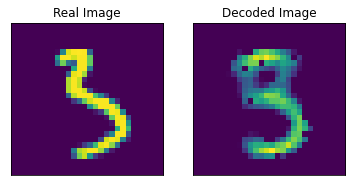

In [81]:
exBatchIdx, (exData, _) = next(enumerate(testLoader))

exInputIdx = np.random.randint(batchSizeTrain)
exImg = exData[exInputIdx]

plt.subplot(1, 2, 1)
plt.title('Real Image')
plt.xticks([])
plt.yticks([])
plt.imshow(exImg[0])
plt.subplot(1, 2, 2)
plt.title('Decoded Image')
plt.xticks([])
plt.yticks([])
plt.imshow(model(exImg.unsqueeze(0))[0][0].detach().numpy())